In [2]:
import numpy as np
import pkg_resources
pkg_resources.require("opencv-python==3.4.2.16")
import cv2 as cv2
import matplotlib.pyplot as plt
import skimage
from skimage import data
from skimage.feature import corner_harris, corner_subpix, corner_peaks
%pylab inline
pylab.rcParams['figure.figsize'] = (12,12)

Populating the interactive namespace from numpy and matplotlib


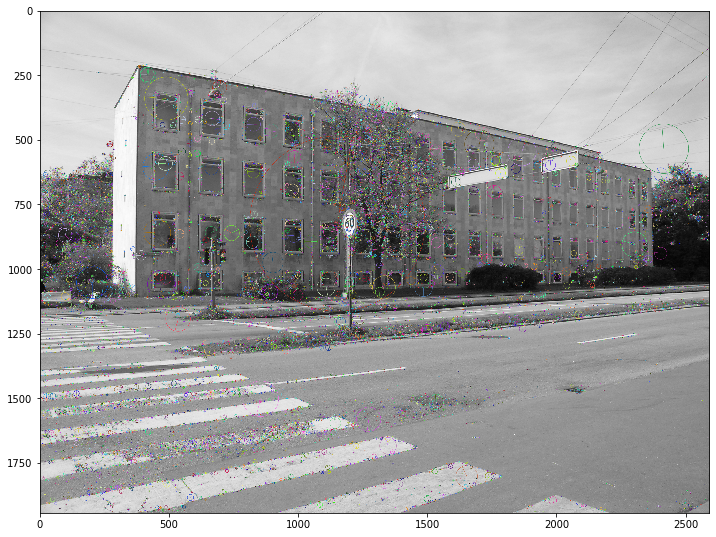

In [7]:
img = cv2.imread('Diku9.jpg')
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create()
# kp,des = sift.detectAndCompute(gray, None)
kp = sift.detect(gray,None)
img=cv2.drawKeypoints(gray,kp,img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#subimg = img[1000:1600, 250:1100]
plt.imshow(img)
plt.show()

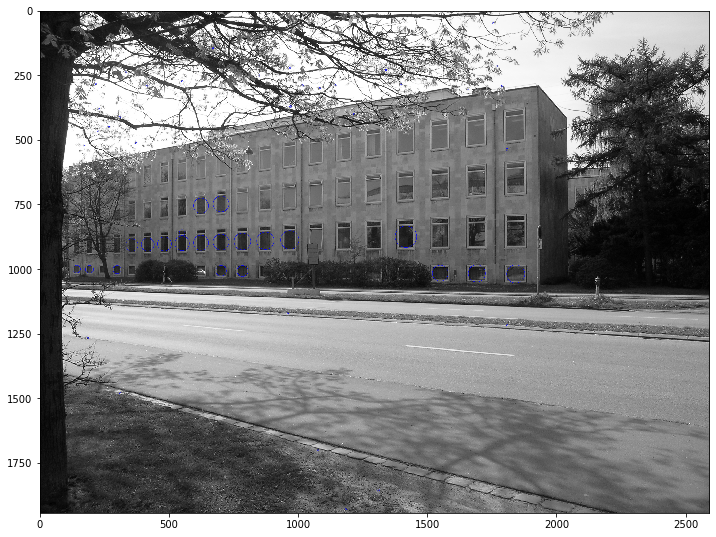

In [11]:
# Read image
im = cv2.imread("Diku13.jpg", cv2.IMREAD_GRAYSCALE)
 
# Set up the detector with default parameters.
detector = cv2.SimpleBlobDetector_create()
 
# Detect blobs.
keypoints = detector.detect(im)
 
# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
im_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(im_with_keypoints)
plt.show()

In [34]:
def CornerDetect(img):
    image = cv2.imread(img, 0)
    #coords = corner_peaks(corner_harris(image), min_distance=1)
    coords = corner_peaks(cv2.cornerHarris(image,2,3,0.04), min_distance=1)

#     fig, ax = plt.subplots()
#     ax.imshow(image, cmap=plt.cm.gray)
#     ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o',
#             linestyle='None', markersize=6)
#     #ax.plot(380, 212, '+r', markersize=15)
#     plt.show()
    return image, coords

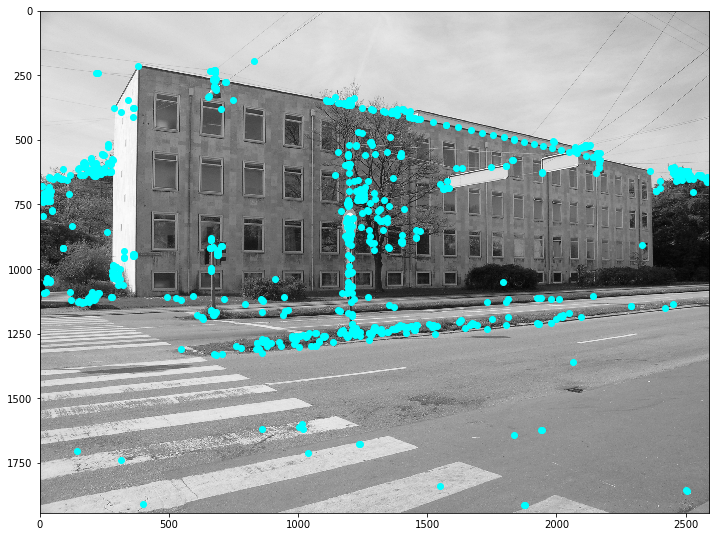

(array([[183, 184, 186, ..., 163, 163, 164],
        [183, 185, 186, ..., 164, 163, 163],
        [183, 183, 184, ..., 165, 165, 165],
        ...,
        [186, 188, 190, ..., 134, 136, 140],
        [184, 187, 187, ..., 131, 134, 138],
        [184, 185, 186, ..., 133, 135, 135]], dtype=uint8),
 array([[ 196,  828],
        [ 213,  380],
        [ 230,  680],
        ...,
        [1910,  400],
        [1912, 1876],
        [1914, 1878]]))

In [6]:
CornerDetect('Diku9.jpg')

In [31]:
def BlobDetector(img):
    im = cv2.imread(img,0)
    # Set up the detector with default parameters.
    detector = cv2.SimpleBlobDetector_create()

    # Detect blobs.
    keypoints = detector.detect(im)
    kps = []
    for i in range(len(keypoints)):
        if keypoints[i].size > 20:
            kps.append(keypoints[i])
    
#     for i in range(len(kps)):
#         s = kps[i].size
#         r = kps[i].response
#         print('size: {}\nresponse: {}'.format(s, r))

    # Draw detected blobs as red circles.
    # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
    im_with_keypoints = cv2.drawKeypoints(im, kps, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.imshow(im_with_keypoints)
    plt.show()
    return im, keypoints

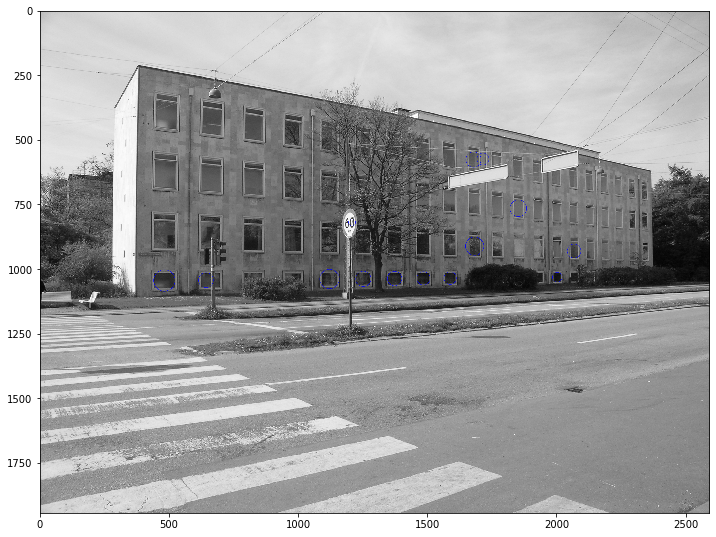

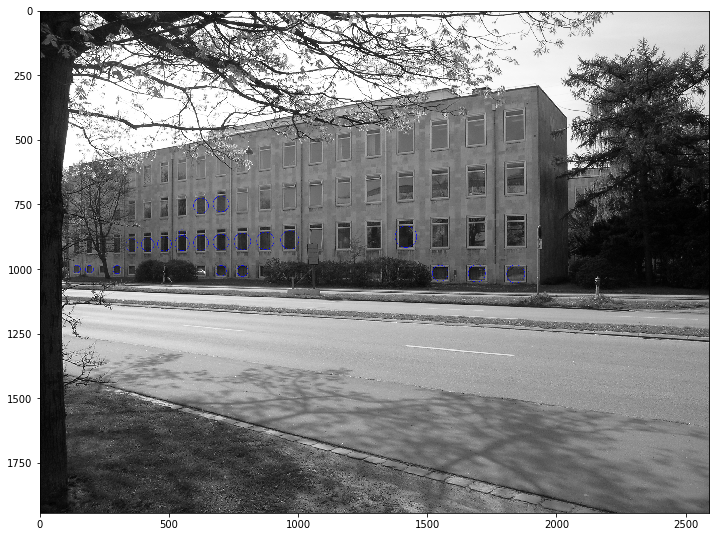

In [35]:
img1, kp1 = BlobDetector('Diku9.jpg')
img2, kp2 = BlobDetector('Diku13.jpg')
img3, kp3 = CornerDetect('skyline15.jpg')
img4, kp4 = CornerDetect('skyline205.jpg')

In [36]:
coords1 = np.array([[kp.pt[1], kp.pt[0]] for kp in kp1]).astype(int)
coords2 = np.array([[kp.pt[1], kp.pt[0]] for kp in kp2]).astype(int)

In [37]:
def ComputeMatches(img1, kp1, img2, kp2, n):
    bestMatches = []
    matches = []
    x1_max, y1_max = img1.shape
    x2_max, y2_max = img2.shape
    for i in range(len(kp1)):
        # Create patch for fp one
        f1 = np.zeros((2 * n + 1, 2 * n + 1))
        x, y = kp1[i]
        for j in range(-n,n+1):
            for k in range(-n,n+1):
                if(x+j >= x1_max or x+j < 0 or y+k >= y1_max or y+k < 0):
                    continue
                f1[j+n,k+n] = img1[x + j, y + k]
        
        diss = []
        # For each kp in kp2        
        for l in range(len(kp2)):
            # Create patch for fp two
            f2 = np.zeros((2 * n + 1, 2 * n + 1))
            x, y = kp2[l]
            for j in range(-n,n+1):
                for k in range(-n,n+1):
                    if(x+j >= x2_max or x+j < 0 or y+k >= y2_max or y+k < 0):
                        continue
                    f2[j+n,k+n] = img2[x + j, y + k]
        
            # Calculate mean and standard deviations
            f1_bar = np.mean(f1)
            f2_bar = np.mean(f2)
            f1_hat = np.std(f1)
            f2_hat = np.std(f2)

            # Standardize
            f1 = f1 - f1_bar
            f1 = f1 / f1_hat
            f2 = f2 - f2_bar
            f2 = f2 / f2_hat
            
            # Calculate dissimilartiy
            d = np.sum((f1 - f2)**2)
            diss.append(d)
        idx = argsort(diss)
        # Best and second best match
        match1 = [i, idx[0], diss[idx[0]]]
        match2 = [i, idx[1], diss[idx[1]]]
        bestMatches.append(match1)
        matches.append(match2)
    return bestMatches, matches

In [38]:
n = 3
best1, second1 = ComputeMatches(img1, coords1, img2, coords2, n)
#best2, second2 = ComputeMatches(image2, coords2, image1, coords1, n)

In [42]:
matches = []
for i in range(len(best1)):
    #best1Match = best1[i][1]
   # best2Match = best2[best1Match][1]
#     if (best1Match == i):
#         matches.append([best2Match, best1Match])
    if (best1[i][2] / second1[i][2] <= 0.8 ):#and best1[i][2] < 12):
        matches.append([best1[i][0], best1[i][1]])

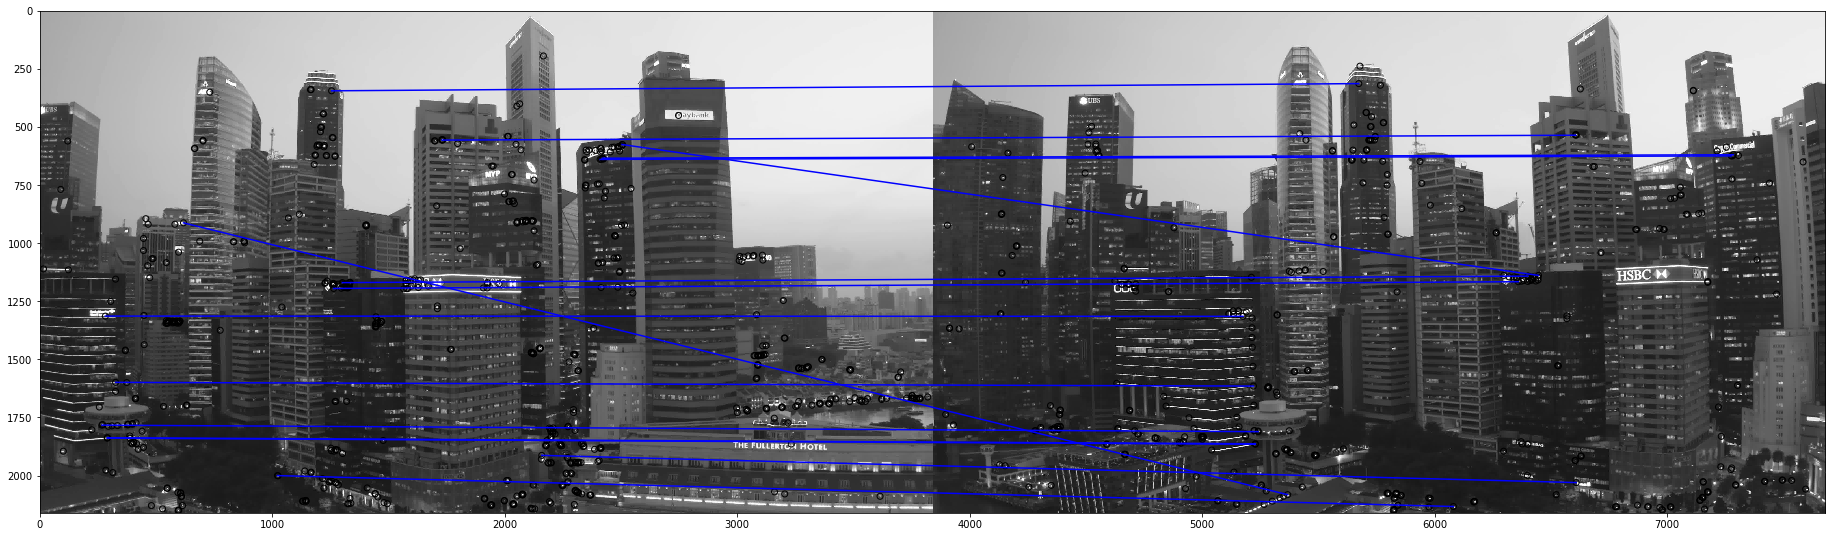

In [104]:
# n = 11, T = 12
fig, ax = plt.subplots(1,1, figsize=(32,32))
skimage.feature.plot_matches(ax,img3,img4,kp3,kp4,np.asarray(matches), matches_color='b')
plt.show()

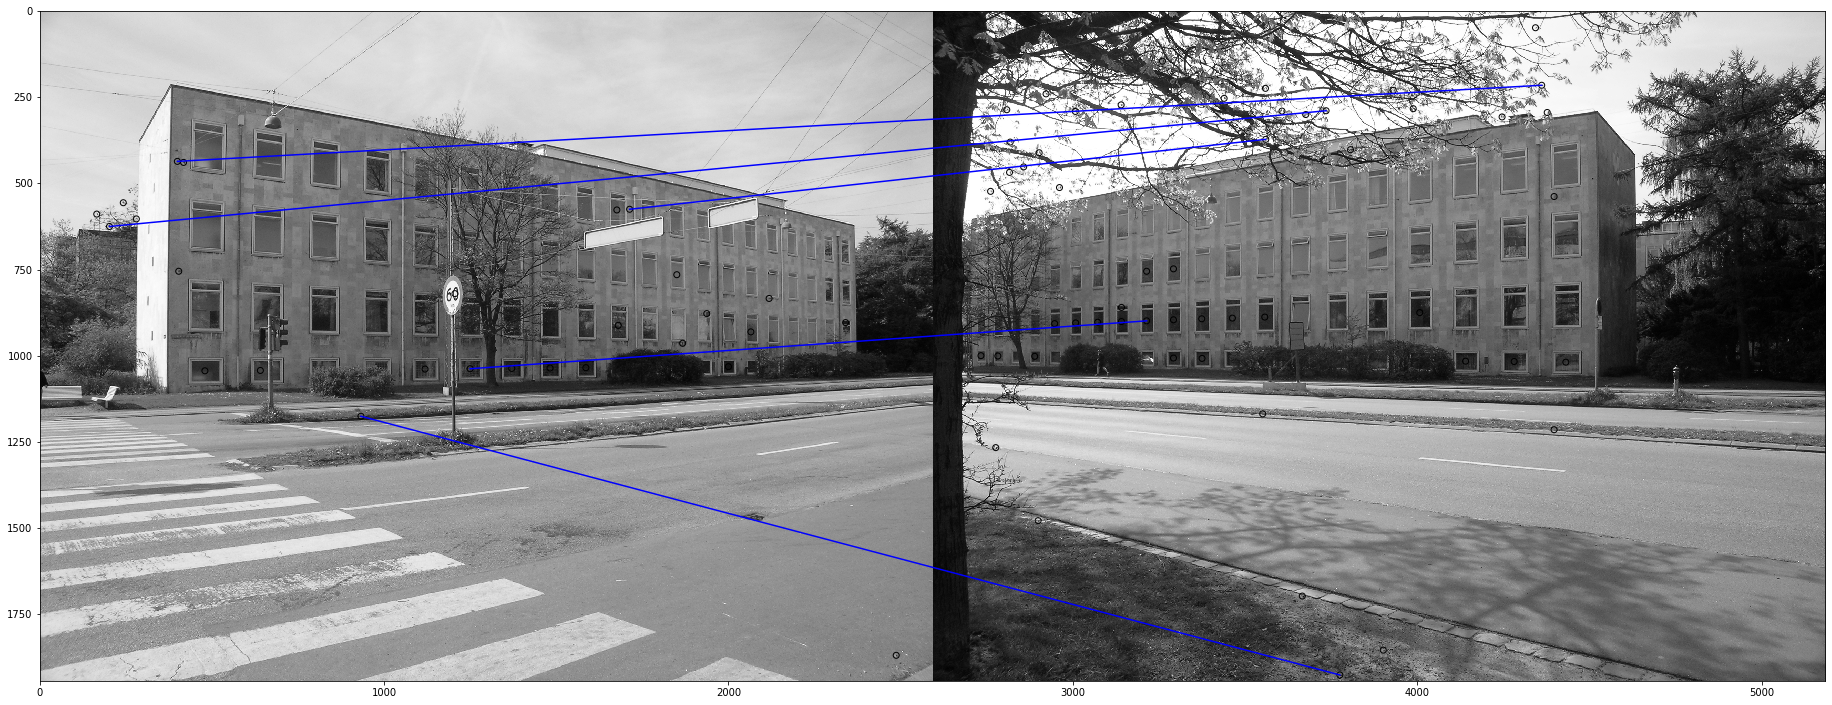

In [43]:
fig, ax = plt.subplots(1,1, figsize=(32,32))
skimage.feature.plot_matches(ax,img1,img2,coords1,coords2,np.asarray(matches), matches_color='b')
plt.show()

In [119]:
a = np.array([[1,1,1,1,1],
              [2,2,2,2,2],
              [3,3,3,3,3],
              [4,4,4,4,4]])
print(a.shape)
m = ComputeMatches(a, [(2,2)], a, [], 2)
a + a
m = m - np.mean(m)
m = m / np.std(m)
print(np.sqrt(np.sum(a + m)))

(4, 5)


IndexError: index 4 is out of bounds for axis 0 with size 4

In [39]:
(3+3)**2

36